In [ ]:
import cv2 
import numpy as np
import argparse
import random as rng
import imutils
import matplotlib.pyplot as plt

In [ ]:
path1='/content/drive/MyDrive/CV_Project_New_York/1.jpg'
image = cv2.imread(path1)


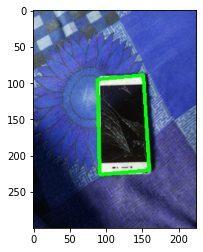

In [ ]:


ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = 300)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.015 * peri, True)
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")
# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]
# multiply the rectangle by the original ratio
rect *= ratio



# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))
# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype = "float32")
# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))
warp1=warp.copy()


# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)

# save the cropped image to file
#cv2.imwrite("cropped.png", crop)
# show our images

plt.imshow( image)
plt.imshow( edged)
plt.imshow( imutils.resize(warp, height = 300))

#cv2.waitKey(0)



cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3) 

plt.imshow( image) 
#cv2.waitKey(0)

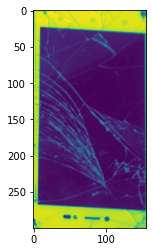

In [ ]:
plt.imshow( imutils.resize(warp, height = 300))

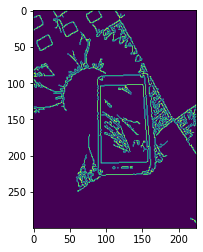

In [ ]:
plt.imshow( edged)

In [ ]:
edged = cv2.Canny(warp, 30, 200)

In [ ]:
k1=200
cont, hier = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for i in cont:
  if(cv2.arcLength(i, False)<k1):
    cv2.drawContours(warp1, i, -1, (255,0,0),3)


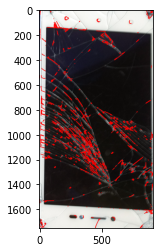

In [ ]:
plt.imshow(warp1)

In [ ]:
from matplotlib.cbook import weakref
import math
import numpy as np
import scipy.ndimage

def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    winE = np.array([[0, 0, 0],[1, 1, 1], [0, 0, 0]])
    winSE = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    winS = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
    winSW = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])

    magE = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    mag[ang_quant == 0] = magE[ang_quant == 0]
    mag[ang_quant == 1] = magSE[ang_quant == 1]
    mag[ang_quant == 2] = magS[ang_quant == 2]
    mag[ang_quant == 3] = magSW[ang_quant == 3]
    return mag

def non_max_suppression(data, win):
    data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

# start calulcation
gray_image = warp
with_nmsup = True #apply non-maximal suppression
fudgefactor = 1.3 #with this threshold you can play a little bit
sigma = 21 #for Gaussian Kernel
kernel = 2*math.ceil(2*sigma)+1 #Kernel size

gray_image = gray_image/255.0
blur = cv2.GaussianBlur(gray_image, (kernel, kernel), sigma)
gray_image = cv2.subtract(gray_image, blur)

# compute sobel response
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
mag = np.hypot(sobelx, sobely)
ang = np.arctan2(sobely, sobelx)

# threshold
threshold = 4 * fudgefactor * np.mean(mag)
mag[mag < threshold] = 0

    

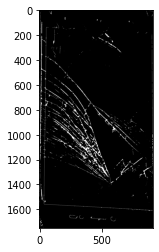

In [ ]:

#either get edges directly
if with_nmsup is False:
    mag = cv2.normalize(mag, 0, 255, cv2.NORM_MINMAX)
    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
    plt.imshow(result,cmap='gray')
#or apply a non-maximal suppression
else:

    # non-maximal suppression
    mag = orientated_non_max_suppression(mag, ang)
    # create mask
    mag[mag > 0] = 255
    mag = mag.astype(np.uint8)

    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
    plt.imshow(result,cmap='gray')